# Here we present *MALDIpy*, a Python-based package for analyzing MALDI-MS imaging mass spectrometry data, including species visualization, single-cell analysis with UMAP clustering and projection of cell type annotations.

* ## In this notebook, we demonstrate how we can use *MALDIpy* for integrative analysis of multiple MALDI-MS datasets. We incorporate matrix normalization in species visualization and incorporate Harmony-based batch correction in single-cell analysis.

In [1]:
import pandas as pd
import scanpy as sc
import scanpy.external as sce
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white',fontsize=12)
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager
import matplotlib.font_manager as fm
import numpy as np
from matplotlib_venn import venn3, venn3_circles, venn2
import anndata

In [2]:
import MALDIpy
from MALDIpy import *
from MALDIpy.msi_data import msi_data

## First, read the imaging mass spectrometry data. The csv files that can be downloaded from the METASPACE platform.
* In this tutorial, raw_file1, raw_file2 and raw_file3 were generated from human kidney cortex, medulla and papilla, respectively.

In [3]:
raw_file1 = pd.read_csv('pixel_data_normed/FDR20/23-0179-haikuo_li-flex-patient3-cortex_pixel_intensities_tic_normalized.csv',sep=',',skiprows=2)
raw_file2 = pd.read_csv('pixel_data_normed/FDR20/23-0179-haikuo_li-flex-pt3-medulla_pixel_intensities_tic_normalized.csv',sep=',',skiprows=2)
raw_file3 = pd.read_csv('pixel_data_normed/FDR20/23-0179-haikuo_li-flex-pt3-papilla_pixel_intensities_tic_normalized.csv',sep=',',skiprows=2)

## The function *msi_data* allows you to create a MALDIpy object which we will start with.

In [4]:
maldi_obj1 = msi_data(raw_file1,scale=10)
maldi_obj2 = msi_data(raw_file2,scale=10)
maldi_obj3 = msi_data(raw_file3,scale=10)

## To begin single-cell analysis, we provide a function called *to_adata*, which can generate an AnnData object from a MALDIpy object.
* Such AnnData object can be processed with [Scanpy](https://scanpy.readthedocs.io/en/stable/index.html), a single-cell analysis tool in Python.
* To simply the Scanpy workflow, we provide three functions, (1) *single_cell.maldifilter*, (2) *single_cell.maldi_norm* and (3) *single_cell.maldi_clustering*, for data filtering/QC, normalization/regress_out/scale and dimension reduction/UMAP/Leiden clustering, respectively.
* Here we are using *single_cell.maldifilter* for initial QC.

In [5]:
adata1 = maldi_obj1.to_adata(add_meta=True, csv_file=raw_file1)
adata2 = maldi_obj2.to_adata(add_meta=True, csv_file=raw_file2)
adata3 = maldi_obj3.to_adata(add_meta=True, csv_file=raw_file3)
for i in [adata1,adata2,adata3]:
    MALDIpy.single_cell.maldifilter(i, min_count=40000, min_gene=30)

filtered out 16479 cells that have less than 40000 counts
filtered out 132 cells that have less than 30 genes expressed
filtered out 33462 cells that have less than 40000 counts
filtered out 300 cells that have less than 30 genes expressed
filtered out 10126 cells that have less than 40000 counts
filtered out 10 cells that have less than 30 genes expressed


In [6]:
print(adata1.shape,adata2.shape,adata3.shape)

(89375, 376) (86939, 306) (64680, 288)


## You can visualize any metabolite of interest with it raw m/z value in each tissue section using the function *plt*.
* Here we are visualizing m/z 741.530654593237, a glomerulus-specific species in the human kidney.

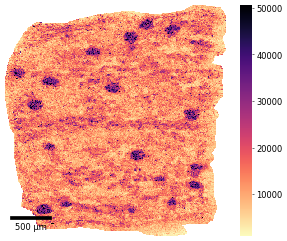

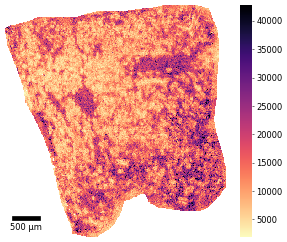

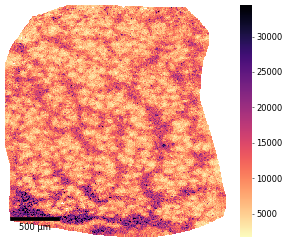

In [7]:
maldi_obj1.plt(mz=741.530654593237, figsize = (6,5), smooth=False, pos = 'lower left', 
                   remove_hs = True, cmap = "magma_r", dpi = 50)
maldi_obj2.plt(mz=741.530654593237, figsize = (6,5), smooth=False, pos = 'lower left', 
                   remove_hs = True, cmap = "magma_r", dpi = 50)
maldi_obj3.plt(mz=741.530654593237, figsize = (6,5), smooth=False, pos = 'lower left', 
                   remove_hs = True, cmap = "magma_r", dpi = 50)

## In the above visualization, you may have found that the scale bars of the three plots are different, so it's hard to make comparisons between these three tissue sections. Here, we use the function *multi_sample.plot3tissues* to concurrently visualize the three tissues under the same scale.
* Obtain the metabolite abundance matrix in each MALDIpy object by using the function *to_img_mtx*.
* We analyzed three samples at once in this example. If you are analyzing a different number of tissues, you could modify our *plot3tissues* function for customized visualization.

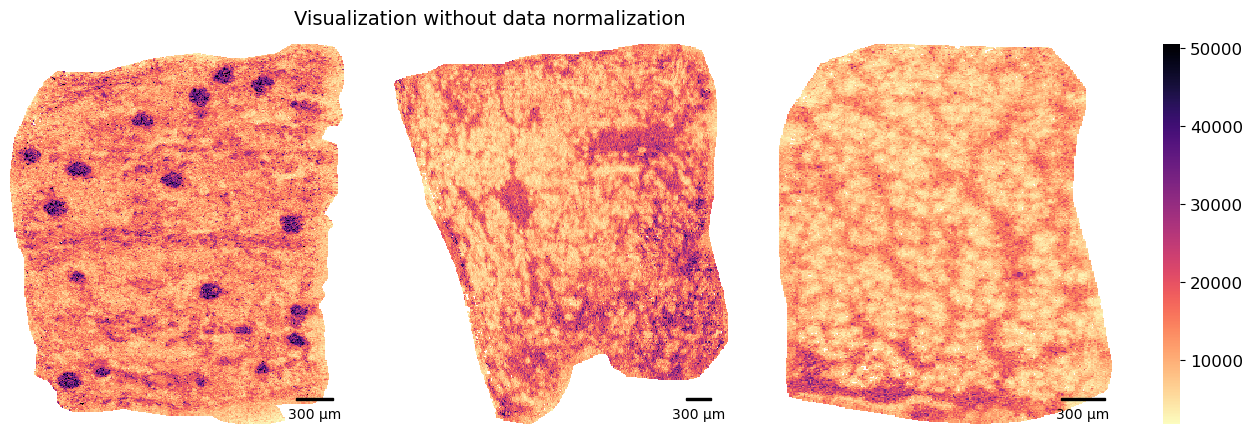

In [8]:
mz_use=741.530654593237
maldi_obj1_mz = maldi_obj1.to_img_mtx(mz=mz_use,smooth=False)
maldi_obj2_mz = maldi_obj2.to_img_mtx(mz=mz_use,smooth=False)
maldi_obj3_mz = maldi_obj3.to_img_mtx(mz=mz_use,smooth=False)

MALDIpy.multi_sample.plot3tissues(maldi_obj1_mz,maldi_obj2_mz,maldi_obj3_mz, title='Visualization without data normalization', cmap = "magma_r")

## However, the above visualization still fails to take batch effects into consideration. It is possible that one of the tissue has a higher baseline of metabolite abundance. Now let's check the mean number of pixel total counts in each tissue.
* Indeed, data1 has the lowest baseline level of metabolite abundance (676082.06); while the other two have a much higher value.
* Therefore, when we plotted m/z 741.530654593237 in the above example, its abundance in tissue2 and tissue3 actually looks higher than expected if we compare them with tissue1.

In [9]:
count_adata1 = np.mean(adata1.obs['total_counts'])
count_adata2 = np.mean(adata2.obs['total_counts'])
count_adata3 = np.mean(adata3.obs['total_counts'])
count_mean = np.mean([count_adata1,count_adata2,count_adata3])

print(count_adata1,count_adata2,count_adata3, count_mean)

676082.06 1154802.6 1130999.9 987294.8


## To normalize such batch effects, here we use a simple linear normalization strategy with the function *to_img_mtx_norm* and provide the *norm_factor* in the function, defined as below.
## -- Now you can see its abundance in tissue2 and tissue3 becomes much lower.
* This is consistent with our expectation because m/z 741.530654593237 is a glomerulus-specific species, and should be mostly present in kidney cortex (tissue1) and less abundant in medulla (tissue2) and papilla (tissue3).

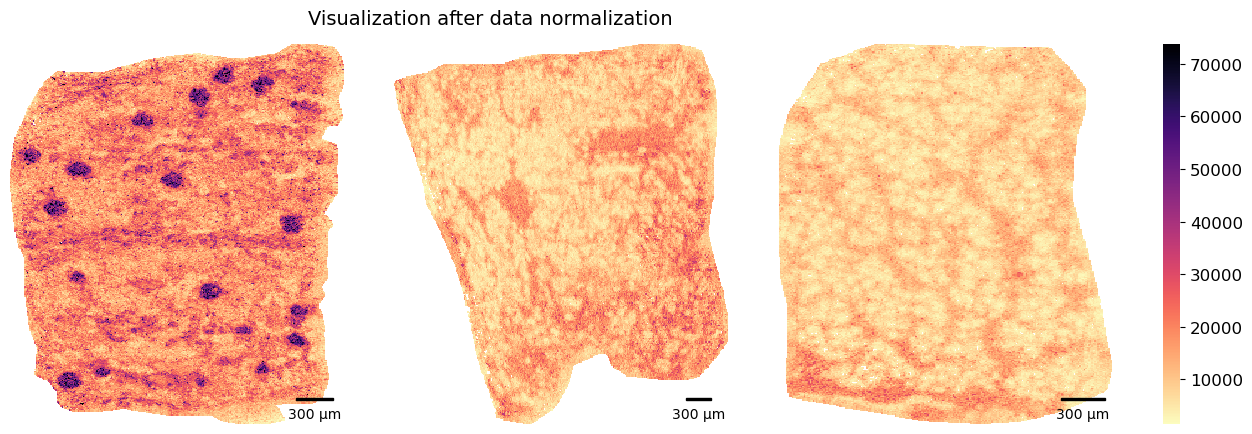

In [10]:
mz_use=741.530654593237
maldi_obj1_mz = maldi_obj1.to_img_mtx_norm(mz=mz_use,smooth=False, norm_factor=count_mean/count_adata1)
maldi_obj2_mz = maldi_obj2.to_img_mtx_norm(mz=mz_use,smooth=False, norm_factor=count_mean/count_adata2)
maldi_obj3_mz = maldi_obj3.to_img_mtx_norm(mz=mz_use,smooth=False, norm_factor=count_mean/count_adata3)

MALDIpy.multi_sample.plot3tissues(maldi_obj1_mz,maldi_obj2_mz,maldi_obj3_mz, title='Visualization after data normalization',cmap = "magma_r")

## Next, we will combine the three datasets together into a single AnnData for downstream analysis.
* In this Venn diagram, you can have a sense how many features are shared and unique.

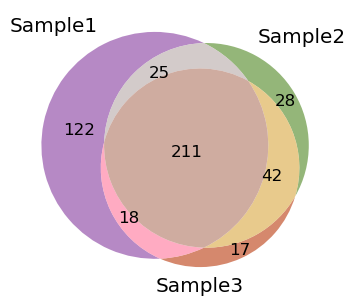

In [11]:
venn3([set(maldi_obj1.mzs), set(maldi_obj2.mzs), set(maldi_obj3.mzs)], 
      set_labels = ('Sample1', 'Sample2','Sample3'),
      set_colors=("#a46cb7","#7aa457","#cb6a49"), alpha = 0.8)

## Here we use the *multi_sample.maldi_concat* function to combine these three dataset into a single AnnData.
* We combined three datasets in this example. If you are analyzing a different number of tissues, you could modify our maldi_concat function for customized analysis.

In [12]:
adata=MALDIpy.multi_sample.maldi_concat(raw_file1,raw_file2,raw_file3, suffix1='data1',suffix2='data2',suffix3='data3')

In [14]:
print(adata.shape)
adata.obs

(301503, 463)


,data_id
x0_y0_data1,data1
x0_y1_data1,data1
x0_y2_data1,data1
x0_y3_data1,data1
x0_y4_data1,data1
...,...
x223_y329_data3,data3
x223_y330_data3,data3
x223_y331_data3,data3
x223_y332_data3,data3


In [15]:
MALDIpy.single_cell.maldifilter(adata, min_count=40000, min_gene=30)

filtered out 60067 cells that have less than 40000 counts
filtered out 442 cells that have less than 30 genes expressed


AnnData object with n_obs × n_vars = 240994 × 463
    obs: 'data_id', 'n_genes_by_counts', 'total_counts', 'n_counts', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [16]:
MALDIpy.single_cell.maldi_norm(adata, regress_out_key='total_counts')

normalizing counts per cell
    finished (0:00:00)
regressing out ['total_counts']
/home/users/hli/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'data_id' as categorical
    finished (0:00:46)
computing PCA
    with n_comps=50
    finished (0:00:06)


AnnData object with n_obs × n_vars = 240994 × 463
    obs: 'data_id', 'n_genes_by_counts', 'total_counts', 'n_counts', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

# The use of [Harmony](https://portals.broadinstitute.org/harmony/articles/quickstart.html) is important if we are integrating multiple MALDI-MS data. Set *use_harmony=True* for this purpose.
* Due to the larger batch difference in MALDI-MS data compared to scRNA-seq data, here we set *theta=5* as default in *single_cell.maldi_clustering*.

In [18]:
MALDIpy.single_cell.maldi_clustering(adata, use_harmony=True, harmony_key='data_id',
                                     n_neighbor=30, n_pc=30, umap_min_dist=0.2,
                                    leiden_res=0.6, leiden_key_added='leiden')

2023-04-06 13:48:53,847 - harmonypy - INFO - Iteration 1 of 10
2023-04-06 13:51:42,822 - harmonypy - INFO - Iteration 2 of 10
2023-04-06 13:54:29,169 - harmonypy - INFO - Iteration 3 of 10
2023-04-06 13:57:07,994 - harmonypy - INFO - Iteration 4 of 10
2023-04-06 13:59:50,181 - harmonypy - INFO - Iteration 5 of 10
2023-04-06 14:02:42,766 - harmonypy - INFO - Iteration 6 of 10
2023-04-06 14:04:38,991 - harmonypy - INFO - Iteration 7 of 10
2023-04-06 14:07:08,699 - harmonypy - INFO - Iteration 8 of 10
2023-04-06 14:08:51,732 - harmonypy - INFO - Converged after 8 iterations
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:35)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:50)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adat

AnnData object with n_obs × n_vars = 240994 × 463
    obs: 'data_id', 'n_genes_by_counts', 'total_counts', 'n_counts', 'n_genes', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## You can see the batch effects between samples have been largely eliminated.

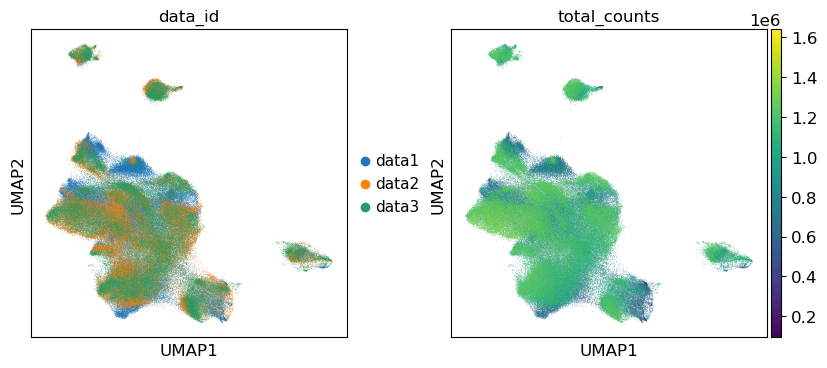

In [23]:
sc.pl.umap(adata, color=['data_id','total_counts'])

## We can visualize the Leiden clustering result on the UMAP space.

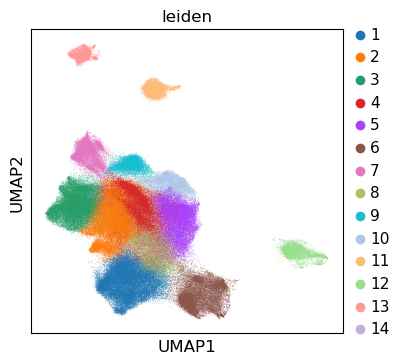

In [24]:
sc.pl.umap(adata, color=['leiden'])

## Here we are checking two glomerulus-specific metabolites.
* You can find they are mainly present in Leiden cluster 1, although cluster 1 also contains cells from medulla (data2) and papilla (data3).
* Increasing leiden_res (leiden_res=0.6 here) is needed for further stratification, though not performed in this tutorial.

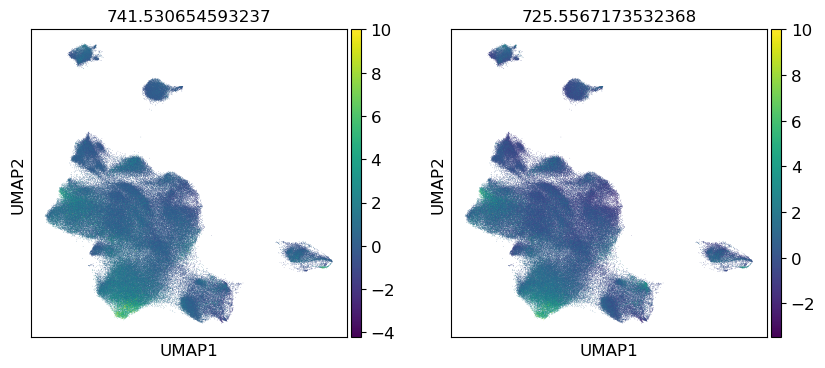

In [25]:
sc.pl.umap(adata, color=['741.530654593237','725.5567173532368'])

## A key feature of this package is to project your single-cell cluster annotations onto the tissue plot. Here, use the function *projection.project3tissues*.
* You can see that in kidney cortex, Leiden cluster 1 presents a kidney glomerulus distribution pattern, consistent with our expectation. Leiden cluster 1 cells are also present in other cell types in medulla and papilla, suggesting further stratification is needed.
* We analyzed three samples in this example. If you are analyzing a different number of tissues, you could modify our project3tissues function for customized visualization.

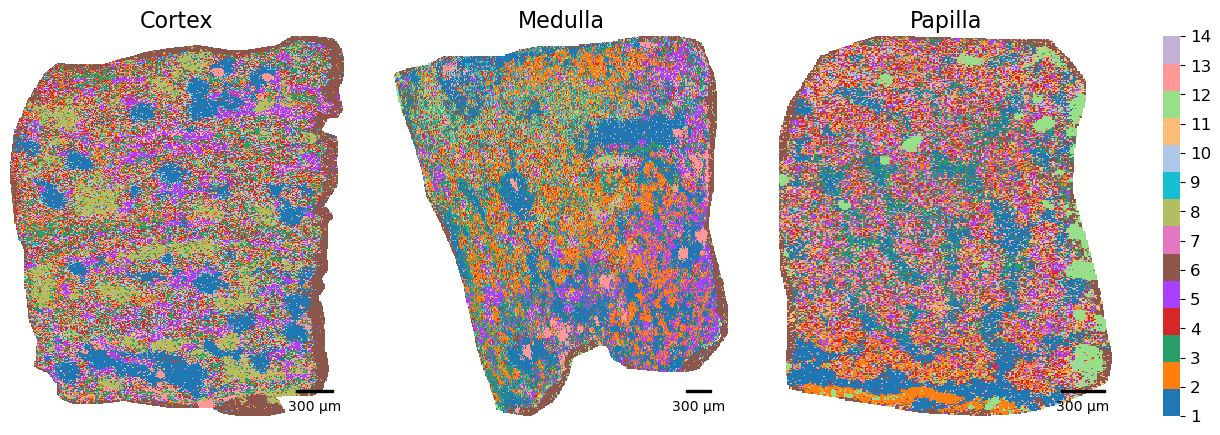

In [26]:
MALDIpy.projection.project3tissues(raw_file1,raw_file2,raw_file3, adata_name=adata,
                                   leiden_key='leiden',suffix1='data1',suffix2='data2',suffix3='data3',
                                   cmap = adata.uns['leiden_colors'],
                                   subtitle1='Cortex',subtitle2='Medulla',subtitle3='Papilla')